In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
#importing machine learning packages

import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn import linear_model, metrics
from sklearn import metrics
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

### 1. Loading Data

In [3]:
# declaring dataframe

sales_item = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
sales_item_category = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
sales_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
sales_train =  pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
sales_test =  pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')


In [4]:
#checking the file

print(sales_item.shape)
print(sales_item_category.shape)
print(sales_shops.shape)
print(sales_train.shape)
print(sales_test.shape)

(22170, 3)
(84, 2)
(60, 2)
(2935849, 6)
(214200, 3)


In [5]:
print("Items : \n",sales_item.head())
print("Item Category : \n",sales_item_category.head())
print("Shops : \n",sales_shops.head())
print("Train : \n",sales_train.head())
print("Test : \n",sales_test.head())

Items : 
                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  
Item Category : 
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4
Shops : 
                         shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"       

In [6]:
# checking null value

print("Items : \n",sales_item.isnull().sum())
print("Item Category : \n",sales_item_category.isnull().sum())
print("Shops : \n",sales_shops.isnull().sum())
print("Train : \n",sales_train.isnull().sum())
print("Test : \n",sales_test.isnull().sum())

Items : 
 item_name           0
item_id             0
item_category_id    0
dtype: int64
Item Category : 
 item_category_name    0
item_category_id      0
dtype: int64
Shops : 
 shop_name    0
shop_id      0
dtype: int64
Train : 
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
Test : 
 ID         0
shop_id    0
item_id    0
dtype: int64


In [7]:
# duplicate counts in train dataset

print('Duplicates in Train : ',len(sales_train[sales_train.duplicated()]))

Duplicates in Train :  6


In [8]:
sales_train[sales_train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1
1435367,2014-02-23,13,50,3423,999.0,1
1496766,2014-03-23,14,21,3423,999.0,1
1671873,2014-01-05,16,50,3423,999.0,1
1866340,2014-12-07,18,25,3423,999.0,1
2198566,2014-12-31,23,42,21619,499.0,1


In [9]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int32         
 2   shop_id         int32         
 3   item_id         int32         
 4   item_price      float32       
 5   item_cnt_day    int32         
dtypes: datetime64[ns](1), float32(1), int32(4)
memory usage: 78.4 MB


In [10]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.906234e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.726440e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


We are downcasting dataframe to save memories

In [11]:
def datatype_downcast(df):
    float_col= [i for i in df if df[i].dtype == 'float64']
    int_col = [i for i in df if df[i].dtype in ['int64','int32']]
    df[float_col] = df[float_col].astype(np.float32)
    df[int_col] = df[int_col].astype(np.int16)
    return df

sales_train = datatype_downcast(sales_train)

sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int16         
 2   shop_id         int16         
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    int16         
dtypes: datetime64[ns](1), float32(1), int16(4)
memory usage: 56.0 MB


In [12]:
sales_dataset = sales_train.copy()

In [13]:
sales_dataset[sales_dataset['item_cnt_day'] == 2169.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169


In [14]:
sales_monthly = sales_dataset.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['mean','max'],'item_price':'mean','item_cnt_day':'sum'})


In [15]:
sales_monthly.head()

date            item_price  \
                                              mean        max       mean   
date_block_num shop_id item_id                                             
0              0       32      2013-02-03 06:00:00 2013-03-01      221.0   
                       33      2013-02-04 00:00:00 2013-03-01      347.0   
                       35      2013-01-31 00:00:00 2013-01-31      247.0   
                       43      2013-01-31 00:00:00 2013-01-31      221.0   
                       51      2013-01-22 00:00:00 2013-01-31      128.5   

                               item_cnt_day  
                                        sum  
date_block_num shop_id item_id               
0              0       32                 6  
                       33                 3  
                       35                 1  
                       43                 1  
                       51                 2

In [16]:
sales_monthly.columns

MultiIndex([(        'date', 'mean'),
            (        'date',  'max'),
            (  'item_price', 'mean'),
            ('item_cnt_day',  'sum')],
           )

### 2.EDA

<AxesSubplot:xlabel='date_block_num'>

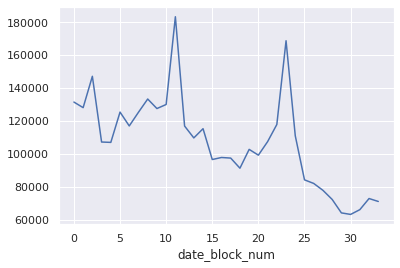

In [17]:
monthly_sales = sales_dataset.groupby(['date_block_num'])['item_cnt_day'].sum()
monthly_sales.plot()

<AxesSubplot:>

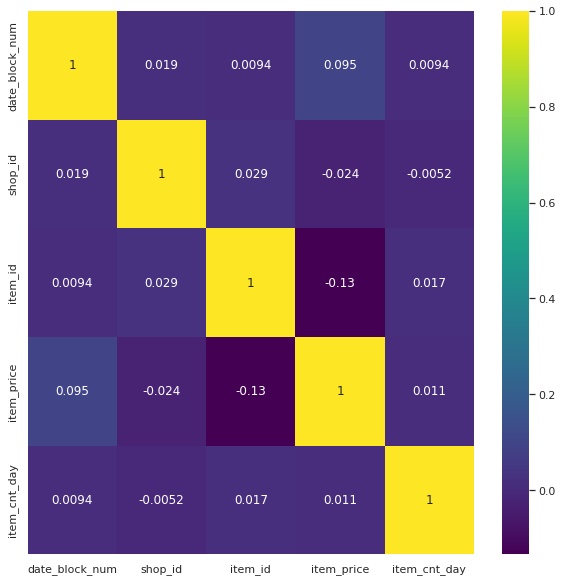

In [18]:
plt.figure(figsize=(10,10))

sns.heatmap(sales_dataset.corr(),cmap='viridis',annot=True)

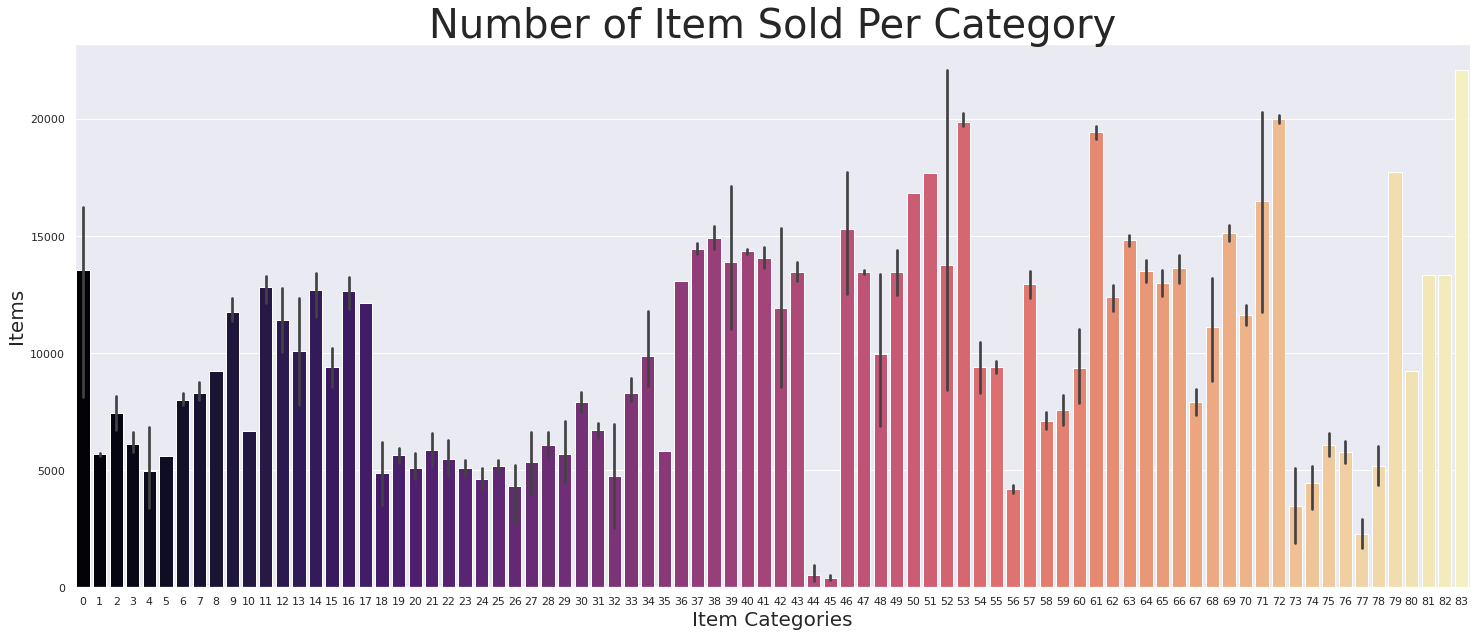

In [19]:
plt.rcParams['figure.figsize'] = (25, 10)
sns.barplot(sales_item['item_category_id'],sales_item['item_id'],palette='magma')
plt.title('Number of Item Sold Per Category', fontsize = 40)
plt.xlabel('Item Categories', fontsize = 20)
plt.ylabel('Items', fontsize = 20)
plt.show()

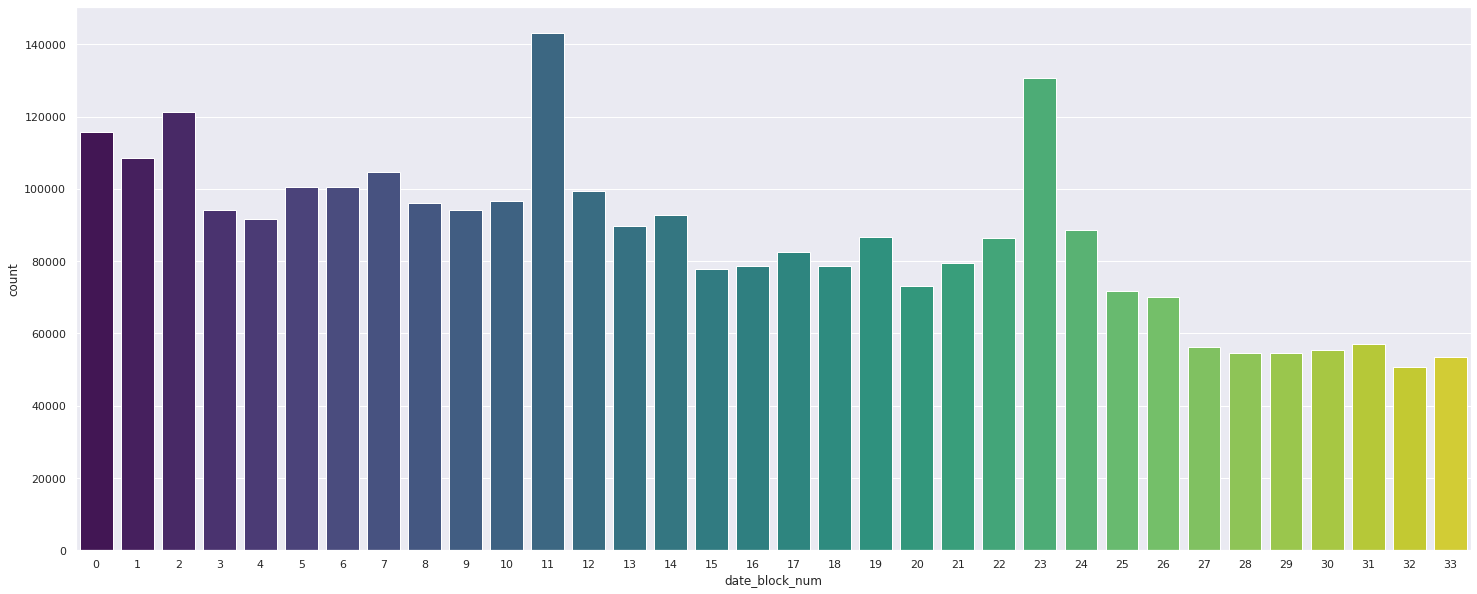

In [20]:
sns.countplot(sales_dataset['date_block_num'],palette='viridis')
plt.show()

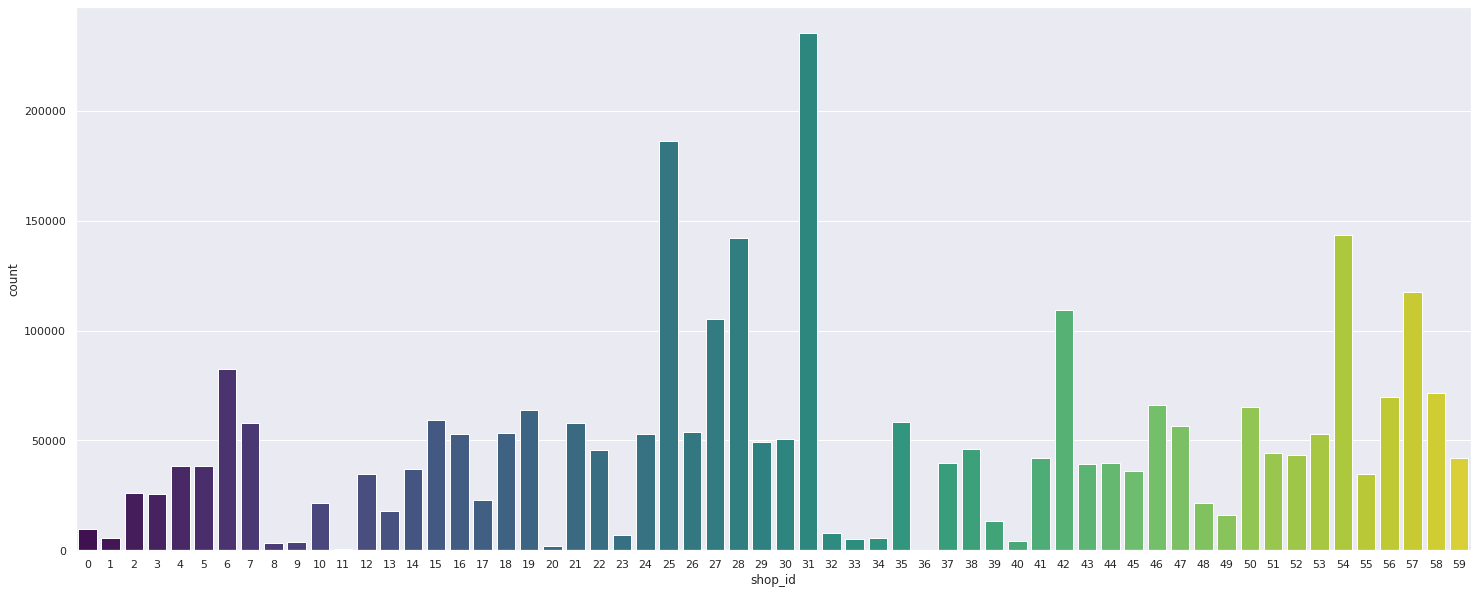

In [21]:
sns.countplot(sales_dataset['shop_id'],palette='viridis')
plt.show()

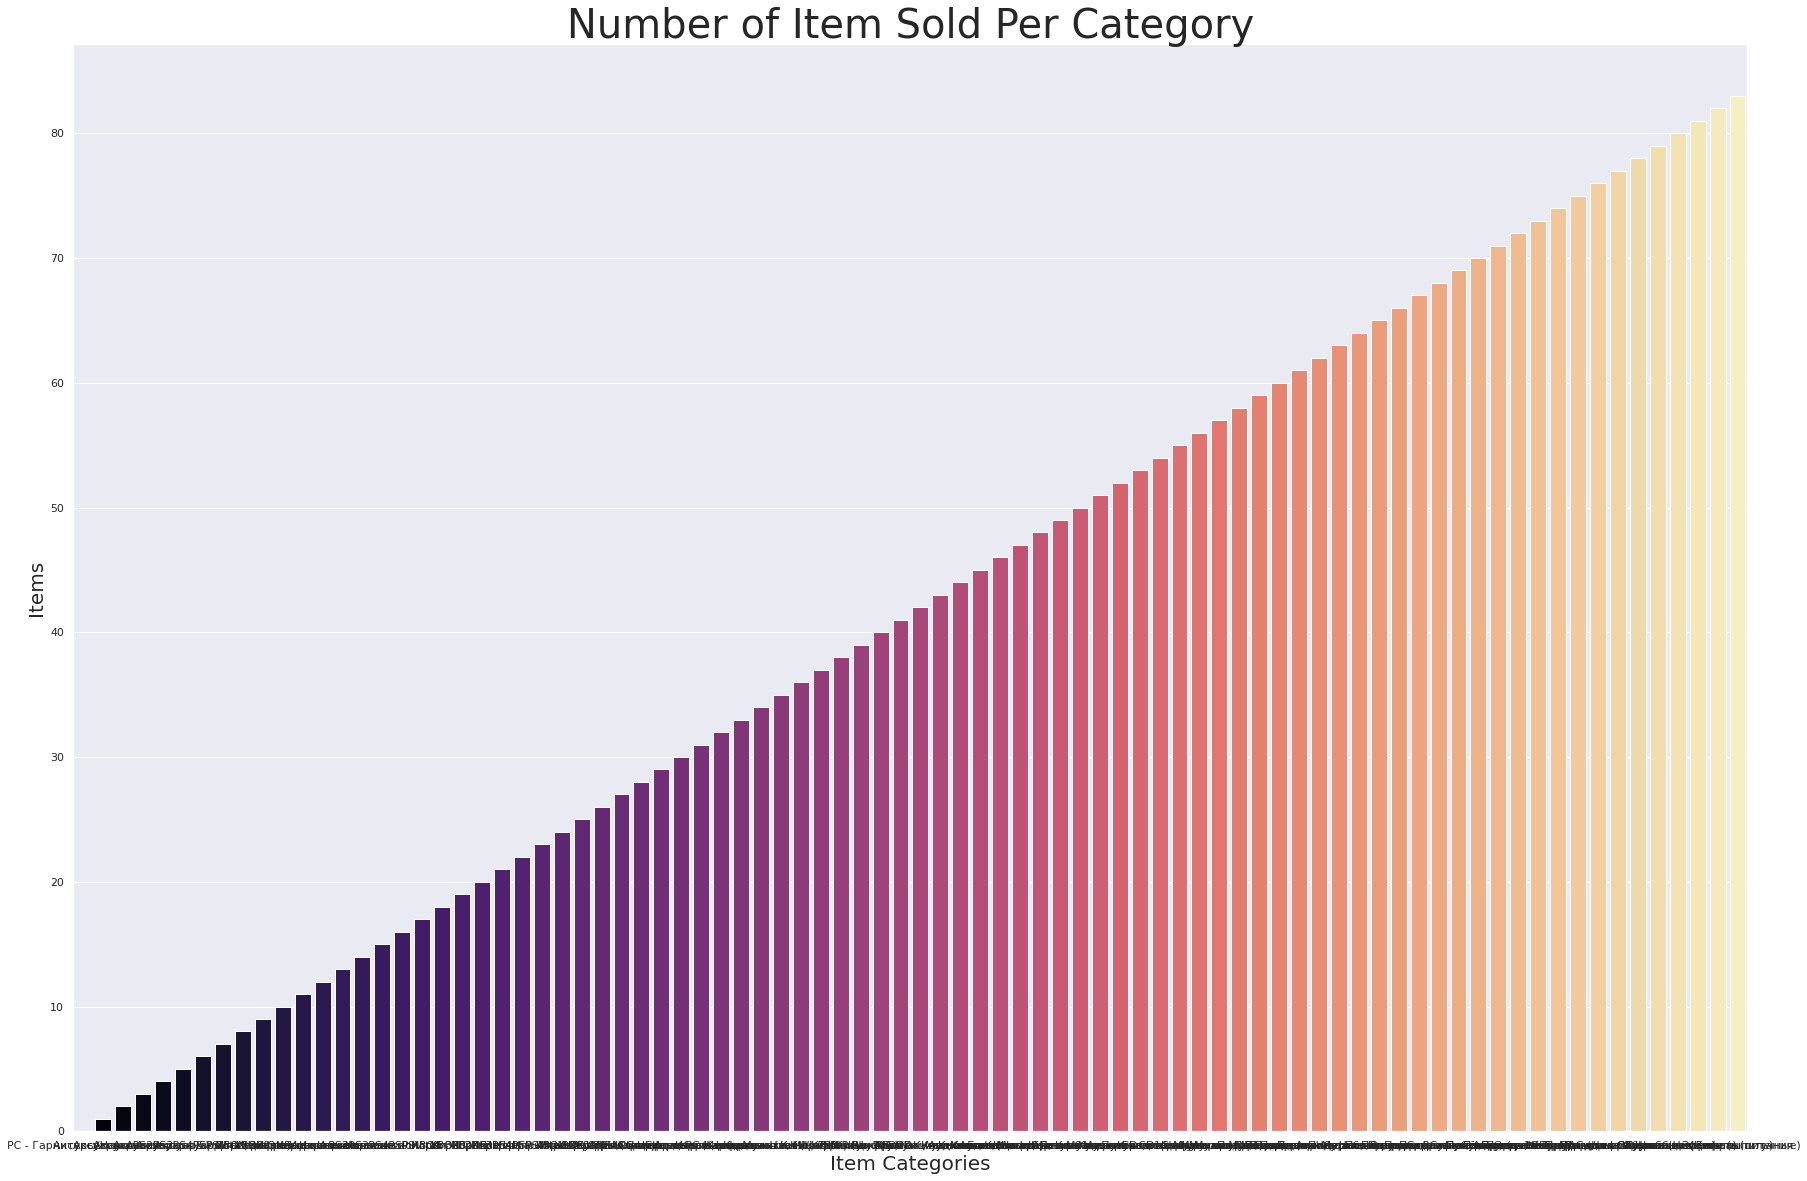

In [22]:
plt.rcParams['figure.figsize'] = (30, 20)
sns.barplot(sales_item_category['item_category_name'],sales_item['item_id'],palette='magma')
plt.title('Number of Item Sold Per Category', fontsize = 40)
plt.xlabel('Item Categories', fontsize = 20)
plt.ylabel('Items', fontsize = 20)
plt.show()

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

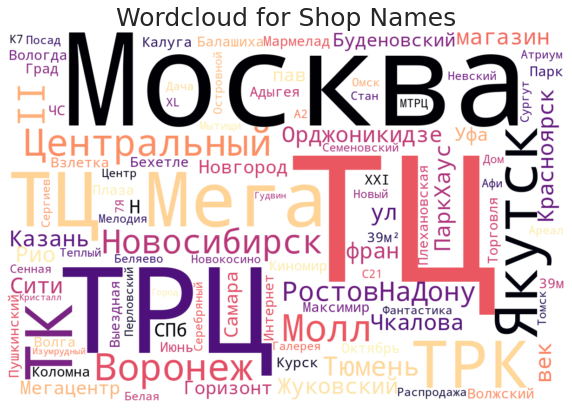

In [24]:
plt.rcParams['figure.figsize'] = (10, 10)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white',
                      colormap='magma',
                      max_words = 100, 
                      stopwords = stopwords ,
                      width = 1200,
                      height = 800,
                     random_state = 30).generate(str(sales_shops['shop_name']))


plt.title('Wordcloud for Shop Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

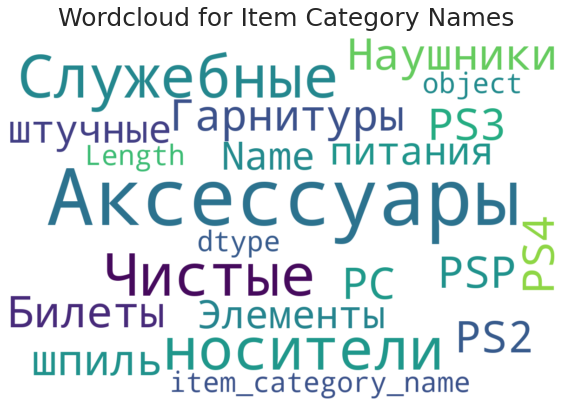

In [25]:
plt.rcParams['figure.figsize'] = (10, 10)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white',
                      colormap='viridis',
                      max_words = 100, 
                      stopwords = stopwords ,
                      width = 1200,
                      height = 800,
                     random_state = 30).generate(str(sales_item_category['item_category_name']))


plt.title('Wordcloud for Item Category Names', fontsize = 25)
plt.axis('off')
plt.imshow(wordcloud, interpolation = 'bilinear')

In [26]:
## Creating Date , Month and Year 

days = []
months = []
years = []

for day in sales_dataset['date']:
    days.append(day.day)
for month in sales_dataset['date']:
    months.append(month.month)
for year in sales_dataset['date']:
    years.append(year.year)

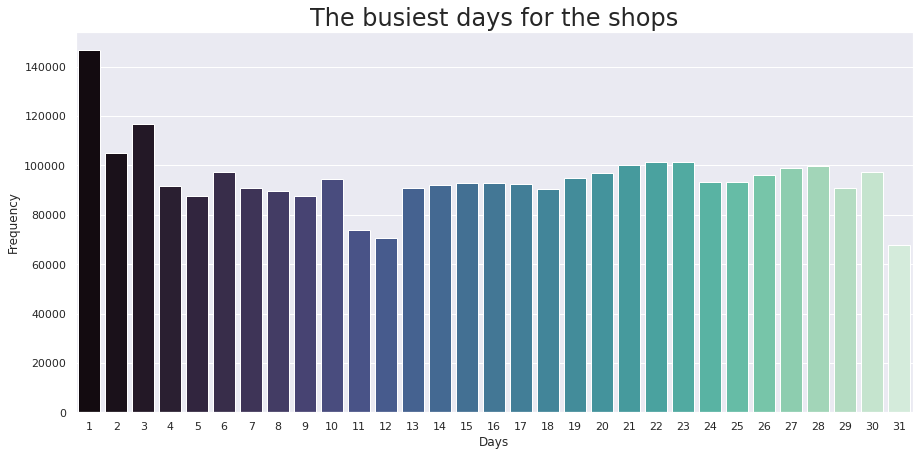

In [27]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(days, palette= 'mako')
plt.title('The busiest days for the shops', fontsize = 24)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

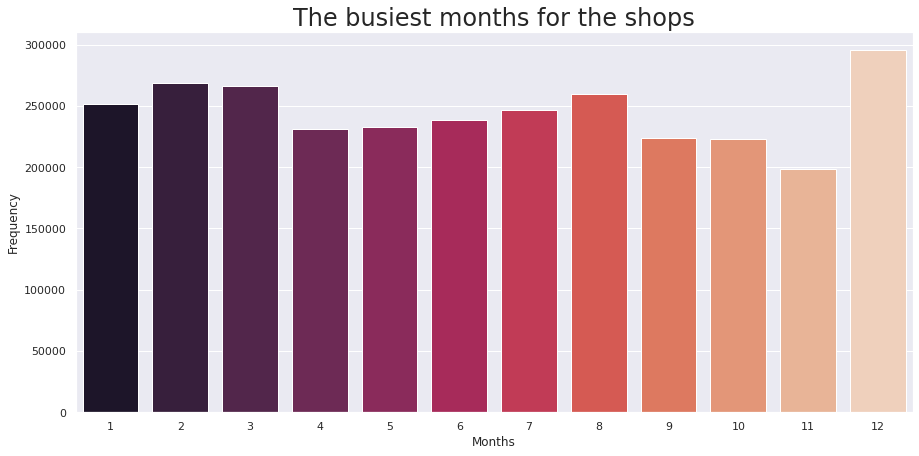

In [28]:
# busy month
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(months, palette= 'rocket')
plt.title('The busiest months for the shops', fontsize = 24)
plt.xlabel('Months', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()


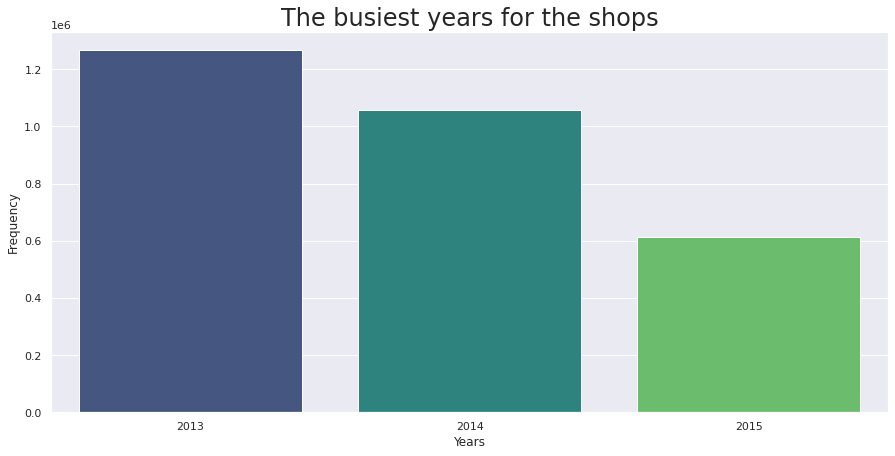

In [29]:

# busy year
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(years, palette= 'viridis')
plt.title('The busiest years for the shops', fontsize = 24)
plt.xlabel('Years', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

In [30]:
sales_dataset['day'] = days
sales_dataset['month'] = months
sales_dataset['year'] = years

In [31]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,1,3,2013
2,2013-05-01,0,25,2552,899.000000,-1,1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,1,6,2013
4,2013-01-15,0,25,2555,1099.000000,1,15,1,2013


<AxesSubplot:xlabel='shop_id', ylabel='count'>

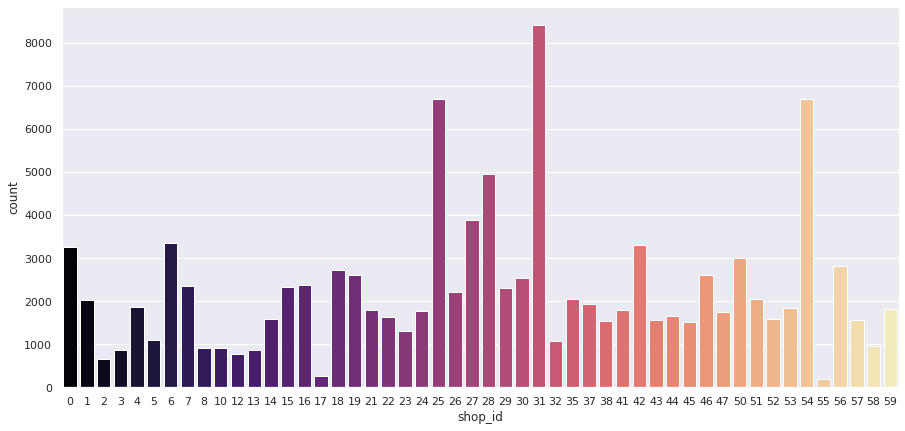

In [32]:
sns.countplot(sales_dataset[(sales_dataset.month == 2) & (sales_dataset.year == 2013)]['shop_id'], palette='magma')

<AxesSubplot:xlabel='item_price'>

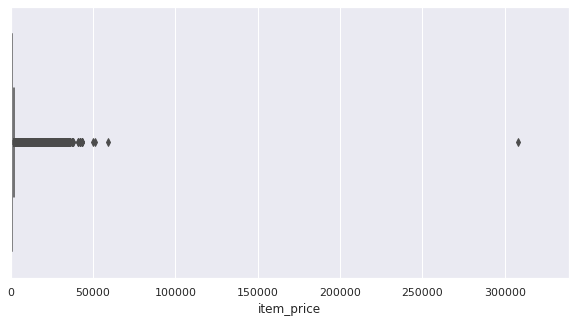

In [33]:
plt.figure(figsize=(10,5))
plt.xlim(sales_dataset.item_price.min(), sales_dataset.item_price.max()*1.1)
sns.boxplot(x=sales_dataset.item_price)

<AxesSubplot:xlabel='item_cnt_day'>

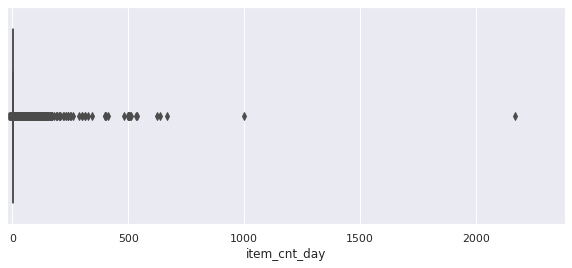

In [34]:
plt.figure(figsize=(10,4))
plt.xlim(sales_dataset.item_cnt_day.min(), sales_dataset.item_cnt_day.max()*1.1)
sns.boxplot(x=sales_dataset.item_cnt_day)

In [35]:
sales_dataset = sales_dataset[sales_dataset['item_price'] < 100000]
sales_dataset = sales_dataset[sales_dataset['item_cnt_day'] < 1200]

In [36]:
sales_dataset.shape

(2935847, 9)

In [37]:
sales_dataset[sales_dataset['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
484683,2013-05-15,4,32,2973,-1.0,1,15,5,2013


In [38]:
sales_median = sales_dataset[(sales_dataset.shop_id==32)&(sales_dataset.item_id==2973)&(sales_dataset.date_block_num==4)&(sales_dataset.item_price>0)].item_price.median()
sales_median

1874.0

In [39]:
sales_dataset["item_price"] = sales_dataset["item_price"].map(lambda x: sales_median if x<0 else x)

In [40]:
sales_dataset[sales_dataset['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year


In [41]:
sales_dataset[sales_dataset['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
2,2013-05-01,0,25,2552,899.0,-1,1,5,2013
148,2013-01-23,0,25,2321,999.0,-1,23,1,2013
175,2013-07-01,0,25,2199,1449.0,-1,1,7,2013
807,2013-02-01,0,25,2330,599.0,-1,1,2,2013
1041,2013-01-13,0,25,5034,1989.0,-1,13,1,2013
...,...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1,26,10,2015
2934462,2015-10-18,33,25,4896,6398.0,-1,18,10,2015
2935263,2015-05-10,33,25,10039,249.0,-1,10,5,2015
2935643,2015-10-16,33,25,7893,2990.0,-1,16,10,2015


In [42]:
sales_dataset['item_cnt_day'] = sales_dataset['item_cnt_day'].map(lambda x:0 if x<0 else x)


In [43]:
sales_dataset[sales_dataset['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year


### 3. Data Preprocessing

In [44]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,1,3,2013
2,2013-05-01,0,25,2552,899.000000,0,1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,1,6,2013
4,2013-01-15,0,25,2555,1099.000000,1,15,1,2013


In [45]:
# checking the uniqueness in shop and test

print("Unique Item : ",sales_item['item_id'].nunique())
print("Unique Item (Train) : ",sales_dataset['item_id'].nunique())
print("Unique Item (Test) : ",sales_test['item_id'].nunique())

Unique Item :  22170
Unique Item (Train) :  21806
Unique Item (Test) :  5100


In [46]:
print("Unique Item : ",sales_shops['shop_id'].nunique())
print("Unique Item (Train) : ",sales_dataset['shop_id'].nunique())
print("Unique Item (Test) : ",sales_test['shop_id'].nunique())

Unique Item :  60
Unique Item (Train) :  60
Unique Item (Test) :  42


In [47]:
test_item_list = [x for x in (np.unique(sales_test['item_id']))]
train_item_list = [x for x in (np.unique(sales_dataset['item_id']))]

missing_item_ids_ = [element for element in test_item_list if element not in train_item_list]
len(missing_item_ids_)

363

Shop Data Processing

In [48]:
sales_shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [49]:
sales_shops['shop_name'] = sales_shops['shop_name'].map(lambda x: x.split('!')[1] if x.startswith('!') else x)

In [50]:
sales_shops['shop_name'] = sales_shops['shop_name'].map(lambda x: 'СергиевПосад ТЦ "7Я"' if x == 'Сергиев Посад ТЦ "7Я"' else x)

In [51]:
sales_shops['shop_name']

0                        Якутск Орджоникидзе, 56 фран
1                        Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

In [52]:
sales_shops['shop_city'] = sales_shops['shop_name'].map(lambda x: x.split(" ")[0])
# lets assign code to these city names too
sales_shops['city_code'] = sales_shops['shop_city'].factorize()[0]

In [53]:
sales_shops

,shop_name,shop_id,shop_city,city_code
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,0
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,4
6,"Воронеж (Плехановская, 13)",6,Воронеж,5
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,5
9,Выездная Торговля,9,Выездная,6


In [54]:
for shop_id in sales_shops['shop_id'].unique():
    sales_shops.loc[shop_id,'num_of_product'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_id'].nunique()
    sales_shops.loc[shop_id,'min_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].min()
    sales_shops.loc[shop_id,'max_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].max()
    sales_shops.loc[shop_id,'mean_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].mean()
    
sales_shops.head()
    

,shop_name,shop_id,shop_city,city_code,num_of_product,min_price,max_price,mean_price
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,0,3600.0,13.0,15653.0,563.444151
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,0,2523.0,13.0,15653.0,515.350652
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1,4849.0,0.1,34990.0,1350.638391
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2,5261.0,0.1,42990.0,1036.840634
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3,7309.0,0.1,34990.0,923.994318


In [55]:
sales_item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [56]:
category_list =[]

for cat_name in sales_item_category['item_category_name']:
    category_list.append(cat_name.split('-'))

category_list

[['PC ', ' Гарнитуры/Наушники'],
 ['Аксессуары ', ' PS2'],
 ['Аксессуары ', ' PS3'],
 ['Аксессуары ', ' PS4'],
 ['Аксессуары ', ' PSP'],
 ['Аксессуары ', ' PSVita'],
 ['Аксессуары ', ' XBOX 360'],
 ['Аксессуары ', ' XBOX ONE'],
 ['Билеты (Цифра)'],
 ['Доставка товара'],
 ['Игровые консоли ', ' PS2'],
 ['Игровые консоли ', ' PS3'],
 ['Игровые консоли ', ' PS4'],
 ['Игровые консоли ', ' PSP'],
 ['Игровые консоли ', ' PSVita'],
 ['Игровые консоли ', ' XBOX 360'],
 ['Игровые консоли ', ' XBOX ONE'],
 ['Игровые консоли ', ' Прочие'],
 ['Игры ', ' PS2'],
 ['Игры ', ' PS3'],
 ['Игры ', ' PS4'],
 ['Игры ', ' PSP'],
 ['Игры ', ' PSVita'],
 ['Игры ', ' XBOX 360'],
 ['Игры ', ' XBOX ONE'],
 ['Игры ', ' Аксессуары для игр'],
 ['Игры Android ', ' Цифра'],
 ['Игры MAC ', ' Цифра'],
 ['Игры PC ', ' Дополнительные издания'],
 ['Игры PC ', ' Коллекционные издания'],
 ['Игры PC ', ' Стандартные издания'],
 ['Игры PC ', ' Цифра'],
 ['Карты оплаты (Кино, Музыка, Игры)'],
 ['Карты оплаты ', ' Live!'],
 ['К

In [57]:
sales_item_category['split'] = (category_list)
sales_item_category['category_type'] = sales_item_category['split'].map(lambda x: x[0])

In [58]:
sales_item_category['category_type_code'] = sales_item_category['category_type'].factorize()[0]

In [59]:
sales_item_category['sub_category_type'] = sales_item_category['split'].map(lambda x: x[1] if len(x)>1 else x[0])

sales_item_category['sub_category_type_code'] = sales_item_category['sub_category_type'].factorize()[0]

In [60]:
sales_item_category.drop('split',axis = 1 ,inplace = True)

sales_item_category.head()

,item_category_name,item_category_id,category_type,category_type_code,sub_category_type,sub_category_type_code
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,0
1,Аксессуары - PS2,1,Аксессуары,1,PS2,1
2,Аксессуары - PS3,2,Аксессуары,1,PS3,2
3,Аксессуары - PS4,3,Аксессуары,1,PS4,3
4,Аксессуары - PSP,4,Аксессуары,1,PSP,4


### 4. Creating New Dataframe by merging

In [61]:
sales_dataset = sales_dataset[sales_dataset['item_cnt_day']>0]
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,1,3,2013
3,2013-06-01,0,25,2554,1709.050049,1,1,6,2013
4,2013-01-15,0,25,2555,1099.000000,1,15,1,2013
5,2013-10-01,0,25,2564,349.000000,1,1,10,2013


In [62]:
sales_dataset = sales_dataset[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(['date_block_num',"shop_id", "item_id"]).agg({"item_price":"mean","item_cnt_day":"sum","month":"min"}).reset_index()


In [63]:
sales_dataset.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,0,0,32,221.0,6,1
1,0,0,33,347.0,3,1


In [64]:
sales_dataset.rename(columns={"item_cnt_day":"item_cnt_month"},inplace=True)

In [65]:
sales_dataset.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_month,month
0,0,0,32,221.0,6,1
1,0,0,33,347.0,3,1


In [66]:
# merging item , shops and category

sales_dataset = pd.merge(sales_dataset,sales_item,on='item_id',how='inner')

sales_dataset = pd.merge(sales_dataset,sales_shops,on='shop_id',how='inner')

sales_dataset = pd.merge(sales_dataset,sales_item_category,on='item_category_id',how='inner')



In [67]:
sales_dataset.head(2).T

,0,1
date_block_num,0,1
shop_id,0,0
item_id,32,32
item_price,221.0,221.0
item_cnt_month,6,10
month,1,2
item_name,1+1,1+1
item_category_id,40,40
shop_name,"Якутск Орджоникидзе, 56 фран","Якутск Орджоникидзе, 56 фран"
shop_city,Якутск,Якутск


In [68]:
sales_dataset.drop(['item_name','shop_name','shop_city','item_category_name','category_type','sub_category_type'],axis = 1,inplace=True)

In [69]:
sales_dataset.head().T

,0,1,2,3,4
date_block_num,0.000000,1.000000,0.000000,1.000000,0.000000
shop_id,0.000000,0.000000,0.000000,0.000000,0.000000
item_id,32.000000,32.000000,35.000000,35.000000,43.000000
item_price,221.000000,221.000000,247.000000,247.000000,221.000000
item_cnt_month,6.000000,10.000000,1.000000,14.000000,1.000000
month,1.000000,2.000000,1.000000,1.000000,1.000000
item_category_id,40.000000,40.000000,40.000000,40.000000,40.000000
city_code,0.000000,0.000000,0.000000,0.000000,0.000000
num_of_product,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000
min_price,13.000000,13.000000,13.000000,13.000000,13.000000


In [70]:
# test dataset

sales_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [71]:
sales_test.shape

(214200, 3)

In [72]:
sales_dataset.shape

(1608225, 14)

In [73]:
sales_dataset = sales_dataset[sales_dataset['shop_id'].isin(sales_test['shop_id'].unique())]
sales_dataset = sales_dataset[sales_dataset['item_id'].isin(sales_test['item_id'].unique())]

In [74]:
sales_dataset.shape

(599912, 14)

In [75]:
sales_train_new = sales_dataset.copy()

sales_train_new = sales_train_new.pivot_table(index=['item_id','shop_id'], columns = 'date_block_num', values = 'item_cnt_month', fill_value = 0).reset_index()

sales_train_new = pd.merge(sales_test,sales_train_new,on = ['item_id','shop_id'],how = 'left')
sales_train_new.fillna(0,inplace = True)

In [76]:
sales_train_new.head().T

,0,1,2,3,4
ID,0.0,1.0,2.0,3.0,4.0
shop_id,5.0,5.0,5.0,5.0,5.0
item_id,5037.0,5320.0,5233.0,5232.0,5268.0
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0


In [77]:
sales_train_new.shape

(214200, 37)

In [78]:
sales_train_new.columns

Index([     'ID', 'shop_id', 'item_id',         0,         1,         2,
               3,         4,         5,         6,         7,         8,
               9,        10,        11,        12,        13,        14,
              15,        16,        17,        18,        19,        20,
              21,        22,        23,        24,        25,        26,
              27,        28,        29,        30,        31,        32,
              33],
      dtype='object')

In [79]:
sales_train_new.isnull().sum()

ID         0
shop_id    0
item_id    0
0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
dtype: int64

### Step 4 : Train Test Split

In [80]:
X = sales_train_new[sales_train_new.columns[:-1]]
X.head().T

,0,1,2,3,4
ID,0.0,1.0,2.0,3.0,4.0
shop_id,5.0,5.0,5.0,5.0,5.0
item_id,5037.0,5320.0,5233.0,5232.0,5268.0
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0


In [81]:
y = sales_train_new[sales_train_new.columns[-1]]
y.head()

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: 33, dtype: float64

In [82]:
# Creating Train and Test for X and y with size 70% and 30%

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 1)

In [83]:
X_test.index

Int64Index([100999,  41385, 129419, 129838,  10995,   8511,  10236, 118810,
             99850,  35261,
            ...
            192316,  82433,  65089,  67245,  25217, 181250, 174608, 164908,
            134641, 108341],
           dtype='int64', length=42840)

**Linear Regression**

In [84]:
# Loading Linear Regression 
lm = LinearRegression()

# Fitting X train and y train
lm.fit(X_train, y_train)


LinearRegression()

In [85]:
# Predicting the X train and X test

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

sales_data_lr_metric = []

# calculating r2 square in Train and Test for Linear Regression
print("R2 Square - Linear Regression")
r2_train_lr = r2_score(y_train, y_pred_train)
print("Train : ",r2_train_lr)
sales_data_lr_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("Test : ",r2_test_lr)
sales_data_lr_metric.append(r2_test_lr)

print('_____________________________________')

#Calculating Residual Sum Of Square (RSS) of Train and Test for Linear Regression

print("Residual Sum Of Square (RSS) - Linear Regression")
rss_train_lr = np.sum(np.square(y_train - y_pred_train))
print("Train : ",rss_train_lr)
sales_data_lr_metric.append(rss_train_lr)

rss_test_lr = np.sum(np.square(y_test - y_pred_test))
print("Test : ",rss_test_lr)
sales_data_lr_metric.append(rss_test_lr)

print('_____________________________________')

# Calculating Mean Squared Error(MSE) of Train and Tes for Linear Regression

print("Mean Squared Error (MSE) - Linear Regression")
mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("Train : ",mse_train_lr)
sales_data_lr_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("Test : ",mse_test_lr)
sales_data_lr_metric.append(mse_test_lr**0.5)

R2 Square - Linear Regression
Train :  0.7328778525914466
Test :  0.45769877725005415
_____________________________________
Residual Sum Of Square (RSS) - Linear Regression
Train :  373065.8489069856
Test :  73947.79871757541
_____________________________________
Mean Squared Error (MSE) - Linear Regression
Train :  2.177088287272325
Test :  1.7261390923803783


In [86]:
print(lm.coef_)

[-6.84214318e-07  1.53789182e-03  2.87228986e-06 -4.50681162e-03
 -1.23184362e-03 -4.38162377e-03  2.48699483e-02 -1.07694036e-01
  3.76691741e-02 -7.44430394e-03  1.54571326e-02 -1.34392054e-02
  4.55717722e-02  4.67003334e-02  1.43889380e-02  2.99045282e-02
 -1.73825129e-01  2.39373263e-02  7.78217664e-04 -1.01062530e-02
 -1.09960044e-02  7.76546261e-02 -2.31932266e-02 -4.70578404e-02
 -8.37628025e-02 -5.15017233e-02  4.32988711e-02  3.51652173e-01
 -2.51511759e-03 -8.87526071e-02  6.85325283e-03  9.23516060e-03
 -9.13093927e-04  1.00483732e-01  1.40988440e-01  3.10916955e-01]


In [87]:
rfe = RFE(lm,50)

rfe = rfe.fit(X_train, y_train)

In [88]:
# Assigning the columns selected by RFE to cols

col = X_train.columns[rfe.support_]

# assigning the 50 features selected using RFE to a dataframe

sales_data_temp = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)), columns=['Variable', 'rfe_support', 'rfe_ranking'])
sales_data_temp = sales_data_temp.loc[sales_data_temp['rfe_support'] == True]

sales_data_temp

,Variable,rfe_support,rfe_ranking
0,ID,True,1
1,shop_id,True,1
2,item_id,True,1
3,0,True,1
4,1,True,1
5,2,True,1
6,3,True,1
7,4,True,1
8,5,True,1
9,6,True,1


In [89]:
X_train_rfe = X_train[col]

In [90]:
X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]


In [91]:
# checking the columns for X train
X_train.columns

Index([     'ID', 'shop_id', 'item_id',         0,         1,         2,
               3,         4,         5,         6,         7,         8,
               9,        10,        11,        12,        13,        14,
              15,        16,        17,        18,        19,        20,
              21,        22,        23,        24,        25,        26,
              27,        28,        29,        30,        31,        32],
      dtype='object')

In [92]:
# list of alphas for Ridge

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# Loadinf Ridge

ridge = Ridge()

# cross validation with fold 5 

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)  
# Fitting the Ridge model cv with X train and Y train 
ridge_model_cv.fit(X_train, y_train) 


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   22.4s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [93]:
print(ridge_model_cv.best_estimator_)

Ridge(alpha=1000)


In [94]:
ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
25,500,-0.370531,-0.376483,2
24,100,-0.370601,-0.376561,3
23,50,-0.370610,-0.376570,4
22,20,-0.370615,-0.376576,5
21,10.0,-0.370617,-0.376578,6
20,9.0,-0.370617,-0.376578,7
19,8.0,-0.370618,-0.376579,8
18,7.0,-0.370618,-0.376579,9
17,6.0,-0.370618,-0.376579,10
16,5.0,-0.370618,-0.376579,11


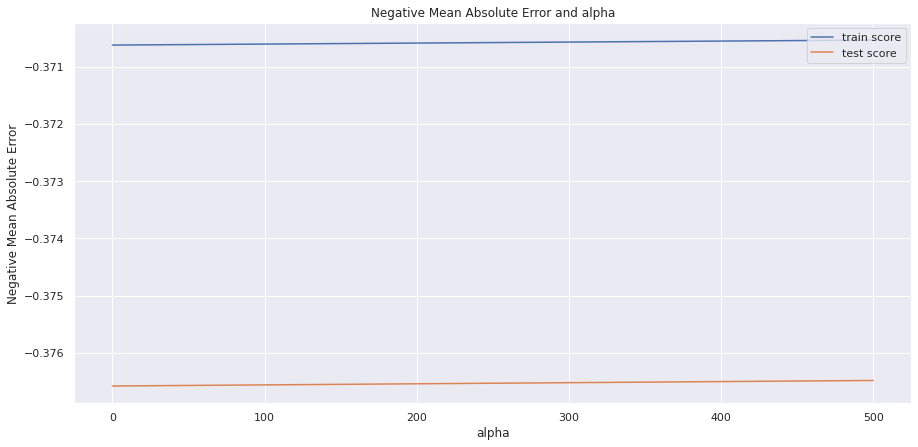

In [95]:
# plotting mean test and train scoes with alpha = 4

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int16')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [96]:
ridge_model_cv.best_params_

{'alpha': 1000}

In [97]:
alpha = 1000
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([-6.84753801e-07,  1.54005928e-03,  2.87125569e-06, -4.45027588e-03,
       -1.24425315e-03, -4.29783075e-03,  2.43622807e-02, -1.07387257e-01,
        3.76642298e-02, -7.46546318e-03,  1.54938974e-02, -1.33675042e-02,
        4.55324404e-02,  4.65952493e-02,  1.42788774e-02,  2.94680152e-02,
       -1.73016381e-01,  2.38066661e-02,  6.63392021e-04, -1.00968177e-02,
       -1.08744250e-02,  7.71443754e-02, -2.28952814e-02, -4.69937966e-02,
       -8.33697254e-02, -5.15223053e-02,  4.36557067e-02,  3.51162946e-01,
       -2.51101805e-03, -8.85843634e-02,  6.91616968e-03,  9.25736247e-03,
       -3.70930916e-04,  1.00145677e-01,  1.40594919e-01,  3.10258946e-01])

In [98]:
print(ridge.coef_)

[-6.84753801e-07  1.54005928e-03  2.87125569e-06 -4.45027588e-03
 -1.24425315e-03 -4.29783075e-03  2.43622807e-02 -1.07387257e-01
  3.76642298e-02 -7.46546318e-03  1.54938974e-02 -1.33675042e-02
  4.55324404e-02  4.65952493e-02  1.42788774e-02  2.94680152e-02
 -1.73016381e-01  2.38066661e-02  6.63392021e-04 -1.00968177e-02
 -1.08744250e-02  7.71443754e-02 -2.28952814e-02 -4.69937966e-02
 -8.33697254e-02 -5.15223053e-02  4.36557067e-02  3.51162946e-01
 -2.51101805e-03 -8.85843634e-02  6.91616968e-03  9.25736247e-03
 -3.70930916e-04  1.00145677e-01  1.40594919e-01  3.10258946e-01]


In [99]:
sales_data_ridge = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
sales_data_ridge.reset_index(drop=True, inplace=True)
sales_data_ridge

,Features,Coefficient
0,ID,-0.0000
1,shop_id,0.0015
2,item_id,0.0000
3,0,-0.0045
4,1,-0.0012
5,2,-0.0043
6,3,0.0244
7,4,-0.1074
8,5,0.0377
9,6,-0.0075


In [100]:
ridge_coeff_dict = dict(pd.Series(ridge.coef_.round(5), index = X_train.columns))
ridge_coeff_dict

{'ID': -0.0,
 'shop_id': 0.00154,
 'item_id': 0.0,
 0: -0.00445,
 1: -0.00124,
 2: -0.0043,
 3: 0.02436,
 4: -0.10739,
 5: 0.03766,
 6: -0.00747,
 7: 0.01549,
 8: -0.01337,
 9: 0.04553,
 10: 0.0466,
 11: 0.01428,
 12: 0.02947,
 13: -0.17302,
 14: 0.02381,
 15: 0.00066,
 16: -0.0101,
 17: -0.01087,
 18: 0.07714,
 19: -0.0229,
 20: -0.04699,
 21: -0.08337,
 22: -0.05152,
 23: 0.04366,
 24: 0.35116,
 25: -0.00251,
 26: -0.08858,
 27: 0.00692,
 28: 0.00926,
 29: -0.00037,
 30: 0.10015,
 31: 0.14059,
 32: 0.31026}

In [101]:
X_train_ridge = X_train[sales_data_ridge.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_ridge, y_train)

In [102]:
# Creatinf function to gety coefficient value

def ridge_find_coefficient(x):
    return ridge_coeff_dict[x]

# Assign top 15 features to a temp dataframe for further display in the bar plot

sales_data_ridge = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
sales_data_ridge = sales_data_ridge.loc[sales_data_ridge['rfe_support'] == True]
sales_data_ridge.reset_index(drop=True, inplace=True)

sales_data_ridge['Coefficient'] = sales_data_ridge['Features'].apply(ridge_find_coefficient)
sales_data_ridge = sales_data_ridge.sort_values(by=['Coefficient'], ascending=False)
sales_data_ridge = sales_data_ridge.head(15)
sales_data_ridge

,Features,rfe_support,rfe_ranking,Coefficient
10,24,True,1,0.35116
14,32,True,1,0.31026
13,31,True,1,0.14059
12,30,True,1,0.10015
5,18,True,1,0.07714
2,10,True,1,0.04660
9,23,True,1,0.04366
1,5,True,1,0.03766
3,12,True,1,0.02947
6,20,True,1,-0.04699


In [103]:
# Doing a RFE to minimise the features to 15
X_train_ridge = X_train[sales_data_ridge.Features]

lm = LinearRegression()
lm.fit(X_train_ridge, y_train)

# running RFE
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_ridge, y_train)

In [104]:
# Creatinf function to gety coefficient value

def ridge_find_coefficient(x):
    return ridge_coeff_dict[x]

# Assign top 15 features to a temp dataframe for further display in the bar plot

sales_data_ridge = pd.DataFrame(list(zip( X_train_ridge.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
sales_data_ridge = sales_data_ridge.loc[sales_data_ridge['rfe_support'] == True]
sales_data_ridge.reset_index(drop=True, inplace=True)

sales_data_ridge['Coefficient'] = sales_data_ridge['Features'].apply(ridge_find_coefficient)
sales_data_ridge = sales_data_ridge.sort_values(by=['Coefficient'], ascending=False)
sales_data_ridge = sales_data_ridge.head(15)
sales_data_ridge

,Features,rfe_support,rfe_ranking,Coefficient
0,24,True,1,0.35116
1,32,True,1,0.31026
2,31,True,1,0.14059
3,30,True,1,0.10015
4,18,True,1,0.07714
5,10,True,1,0.04660
6,23,True,1,0.04366
7,5,True,1,0.03766
8,12,True,1,0.02947
9,20,True,1,-0.04699


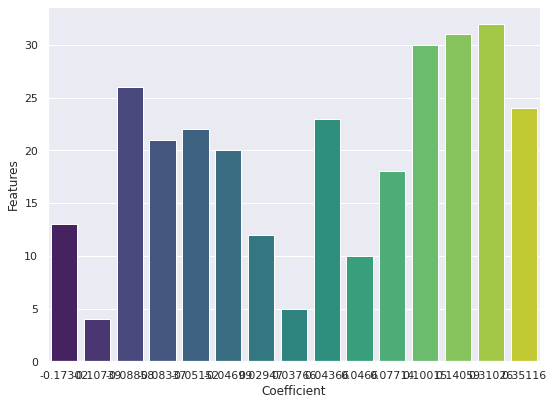

In [105]:
plt.figure(figsize = (30,30))

plt.subplot(4,3,1)

sns.barplot(x='Coefficient' , y = 'Features' , palette='viridis',data = sales_data_ridge)

plt.show()

In [106]:
# Predicting the X train and X test in ridge

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

sales_data_ridge_metric = []

# calculating r2 square in Train and Test for Ridge Regression
print("R2 Square - Ridge Regression")
r2_train_ridge = r2_score(y_train, y_pred_train)
print("Train : ",r2_train_ridge)
sales_data_ridge_metric.append(r2_train_ridge)

r2_test_ridge = r2_score(y_test, y_pred_test)
print("Test : ",r2_test_ridge)
sales_data_ridge_metric.append(r2_test_ridge)

print('_____________________________________')

#Calculating Residual Sum Of Square (RSS) of Train and Test for Ridge Regression

print("Residual Sum Of Square (RSS) - Ridge Regression")
rss_train_ridge = np.sum(np.square(y_train - y_pred_train))
print("Train : ",rss_train_ridge)
sales_data_ridge_metric.append(rss_train_ridge)

rss_test_ridge = np.sum(np.square(y_test - y_pred_test))
print("Test : ",rss_test_ridge)
sales_data_ridge_metric.append(rss_test_ridge)

print('_____________________________________')

# Calculating Mean Squared Error(MSE) of Train and Test for Ridge Regression

print("Mean Squared Error (MSE) - Ridge Regression")
mse_train_ridge = mean_squared_error(y_train, y_pred_train)
print("Train : ",mse_train_ridge)
sales_data_ridge_metric.append(mse_train_ridge)

mse_test_ridge = mean_squared_error(y_test, y_pred_test)
print("Test : ",mse_test_ridge)
sales_data_ridge_metric.append(mse_test_ridge)

R2 Square - Ridge Regression
Train :  0.7328773106300507
Test :  0.45787020516683585
_____________________________________
Residual Sum Of Square (RSS) - Ridge Regression
Train :  373066.60581647506
Test :  73924.42293202865
_____________________________________
Mean Squared Error (MSE) - Ridge Regression
Train :  2.177092704344509
Test :  1.7255934391229844


Text(0, 0.5, 'Sales Price')

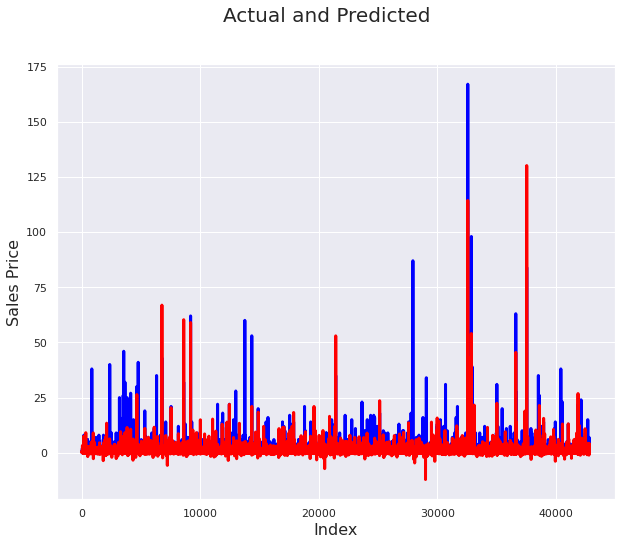

In [107]:
#Ridge visualization for train and test

colz = [i for i in range(0,y_test.shape[0],1)]

fig = plt.figure(figsize=(10,8))

plt.plot(colz,y_test,color='blue',linewidth=3.0,linestyle='-')

plt.plot(colz,y_pred_test,color='red',linewidth=3.0,linestyle='-')

fig.suptitle('Actual and Predicted', fontsize=20)

plt.xlabel('Index', fontsize=16)
plt.ylabel('Sales Price', fontsize=16) 

In [108]:
#Setting Alphas for Lasso
params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}


# loading Lasso

lasso = Lasso()

# cross validation with fold 5

folds = 5

lasso_model_cv = GridSearchCV(estimator = lasso, 
                              param_grid = params,
                              cv = folds,
                              scoring = 'neg_mean_absolute_error',
                              return_train_score = True,
                              verbose = 1)

# fitting the lasso model with X_train and y_train
lasso_model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [109]:
# Displaying the mean scores of Lasso

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
10,0.01,-0.367388,-0.372994,1
9,0.005,-0.368868,-0.374655,2
8,0.004,-0.369196,-0.375016,3
7,0.003,-0.369533,-0.375387,4
6,0.002,-0.369884,-0.375775,5
5,0.001,-0.370247,-0.376174,6
4,0.0005,-0.370432,-0.376377,7
3,0.0004,-0.370470,-0.376417,8
2,0.0003,-0.370507,-0.376458,9
1,0.0002,-0.370544,-0.376498,10


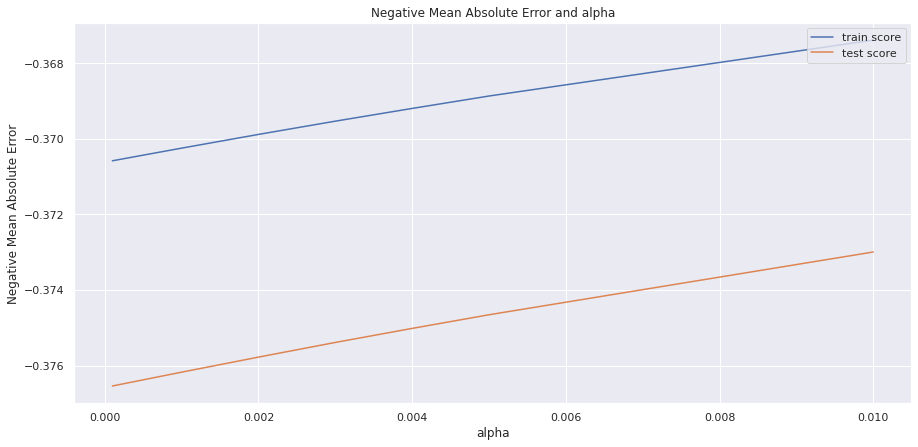

In [110]:
# plotting mean train and test scores with alpha 

lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float64')

# plotting the train and test data

plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [111]:
# checking the lambda
lasso_model_cv.best_estimator_

Lasso(alpha=0.01)

In [112]:
#checking the coefficients with lambda = 0.0001
alpha = 0.0001

lasso = Lasso(alpha=alpha)

lasso.fit(X_train,y_train)

lasso.coef_

array([-6.84010705e-07,  1.53727885e-03,  2.87385134e-06, -4.41986835e-03,
       -1.15943200e-03, -4.30526133e-03,  2.45659170e-02, -1.07663907e-01,
        3.76304273e-02, -7.28853775e-03,  1.53852088e-02, -1.34100060e-02,
        4.55459467e-02,  4.66788508e-02,  1.43518598e-02,  2.97936371e-02,
       -1.73668410e-01,  2.39261354e-02,  6.78930867e-04, -1.00434424e-02,
       -1.09339835e-02,  7.74792570e-02, -2.30701570e-02, -4.70127564e-02,
       -8.37254064e-02, -5.14699581e-02,  4.32512758e-02,  3.51642025e-01,
       -2.43409347e-03, -8.87592857e-02,  6.84436912e-03,  9.20402869e-03,
       -6.95536345e-04,  1.00336153e-01,  1.40914928e-01,  3.10909132e-01])

In [113]:
# Displaying the Shortlisted Features and Coefficients in a house pricing dataframe

sales_data_lasso = pd.DataFrame({'Features':X_train.columns, 'Coefficient':lasso.coef_.round(4)})
sales_data_lasso = sales_data_lasso[sales_data_lasso['Coefficient'] != 0.00]
sales_data_lasso.reset_index(drop=True, inplace=True)
sales_data_lasso

,Features,Coefficient
0,shop_id,0.0015
1,0,-0.0044
2,1,-0.0012
3,2,-0.0043
4,3,0.0246
5,4,-0.1077
6,5,0.0376
7,6,-0.0073
8,7,0.0154
9,8,-0.0134


In [114]:
# Adding the lasso features and coefficients in dictionary for graphing purpose

lasso_coeff_dict = dict(pd.Series(lasso.coef_, index = X_train.columns))
lasso_coeff_dict

{'ID': -6.840107053902047e-07,
 'shop_id': 0.001537278852163896,
 'item_id': 2.873851338213963e-06,
 0: -0.0044198683541228564,
 1: -0.0011594319967384917,
 2: -0.004305261334787519,
 3: 0.02456591701114451,
 4: -0.10766390719544953,
 5: 0.03763042730030634,
 6: -0.007288537751260751,
 7: 0.015385208753751333,
 8: -0.013410005971688859,
 9: 0.045545946700025,
 10: 0.046678850797010285,
 11: 0.014351859805895267,
 12: 0.02979363707154792,
 13: -0.1736684096961996,
 14: 0.023926135384634884,
 15: 0.0006789308670796227,
 16: -0.010043442449699656,
 17: -0.010933983452015923,
 18: 0.07747925702948494,
 19: -0.023070157015944778,
 20: -0.04701275641446616,
 21: -0.08372540638319081,
 22: -0.05146995808018188,
 23: 0.04325127580979578,
 24: 0.35164202492840074,
 25: -0.002434093473861482,
 26: -0.08875928574472655,
 27: 0.006844369116316631,
 28: 0.009204028690474667,
 29: -0.0006955363447245451,
 30: 0.10033615335683528,
 31: 0.14091492835787697,
 32: 0.3109091320788126}

In [115]:
# Doing the RFE to minimise the features to 15 for Lasso
X_train_lasso = X_train[sales_data_lasso.Features]

lm = LinearRegression()
lm.fit(X_train_lasso, y_train)

# running RFE for Lasso
rfe = RFE(lm, 15)            
rfe = rfe.fit(X_train_lasso, y_train)

In [116]:
def lasso_find_coefficient(x):
    return lasso_coeff_dict[x]

# Assign top 15 features to a temp dataframe for further display in the bar plot

sales_data_lasso = pd.DataFrame(list(zip( X_train_lasso.columns, rfe.support_, rfe.ranking_)), columns=['Features', 'rfe_support', 'rfe_ranking'])
sales_data_lasso = sales_data_lasso.loc[sales_data_lasso['rfe_support'] == True]
sales_data_lasso.reset_index(drop=True, inplace=True)

sales_data_lasso['Coefficient'] = sales_data_lasso['Features'].apply(lasso_find_coefficient)
sales_data_lasso = sales_data_lasso.sort_values(by=['Coefficient'], ascending=False)
sales_data_lasso = sales_data_lasso.head(15)
sales_data_lasso

,Features,rfe_support,rfe_ranking,Coefficient
10,24,True,1,0.351642
14,32,True,1,0.310909
13,31,True,1,0.140915
12,30,True,1,0.100336
5,18,True,1,0.077479
2,10,True,1,0.046679
9,23,True,1,0.043251
1,5,True,1,0.037630
3,12,True,1,0.029794
6,20,True,1,-0.047013


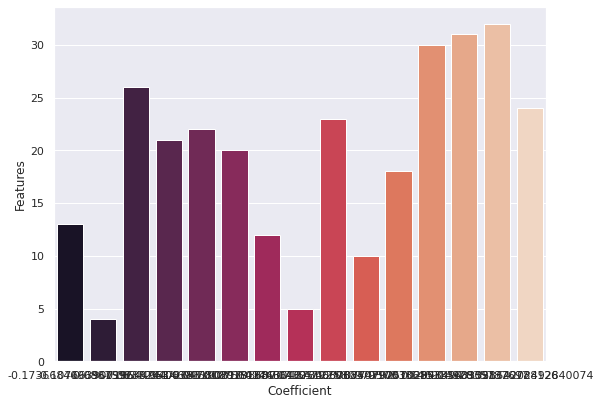

In [117]:
# Plotting the blot plot to determine the variables that would affect pricing of the house based on Lasso Regression

plt.figure(figsize = (30,30))

plt.subplot(4,3,1)

sns.barplot(x='Coefficient' , y = 'Features' , palette='rocket',data = sales_data_lasso)

plt.show()

In [118]:
# Predicting the X train and X test in lasso

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

sales_data_lasso_metric = []

# calculating r2 square in Train and Test for Lasso Regression
print("R2 Square - Lasso Regression")
r2_train_lasso = r2_score(y_train, y_pred_train)
print("Train : ",r2_train_lasso)
sales_data_lasso_metric.append(r2_train_lasso)

r2_test_lasso = r2_score(y_test, y_pred_test)
print("Test : ",r2_test_lasso)
sales_data_lasso_metric.append(r2_test_lasso)

print('_____________________________________')

#Calculating Residual Sum Of Square (RSS) of Train and Test for Lasso Regression

print("Residual Sum Of Square (RSS) - Lasso Regression")
rss_train_lasso = np.sum(np.square(y_train - y_pred_train))
print("Train : ",rss_train_lasso)
sales_data_lasso_metric.append(rss_train_lasso)

rss_test_lasso = np.sum(np.square(y_test - y_pred_test))
print("Test : ",rss_test_lasso)
sales_data_lasso_metric.append(rss_test_lasso)

print('_____________________________________')

# Calculating Mean Squared Error(MSE) of Train and Test for Lasso Regression

print("Mean Squared Error (MSE) - Lasso Regression")
mse_train_lasso = mean_squared_error(y_train, y_pred_train)
print("Train : ",mse_train_lasso)
sales_data_lasso_metric.append(mse_train_lasso)

mse_test_lasso = mean_squared_error(y_test, y_pred_test)
print("Test : ",mse_test_lasso)
sales_data_lasso_metric.append(mse_test_lasso)

R2 Square - Lasso Regression
Train :  0.7328778221164156
Test :  0.45772560133422546
_____________________________________
Residual Sum Of Square (RSS) - Lasso Regression
Train :  373065.89146876277
Test :  73944.14100504616
_____________________________________
Mean Squared Error (MSE) - Lasso Regression
Train :  2.177088535648709
Test :  1.7260537116023846


Text(0, 0.5, 'Sales Price')

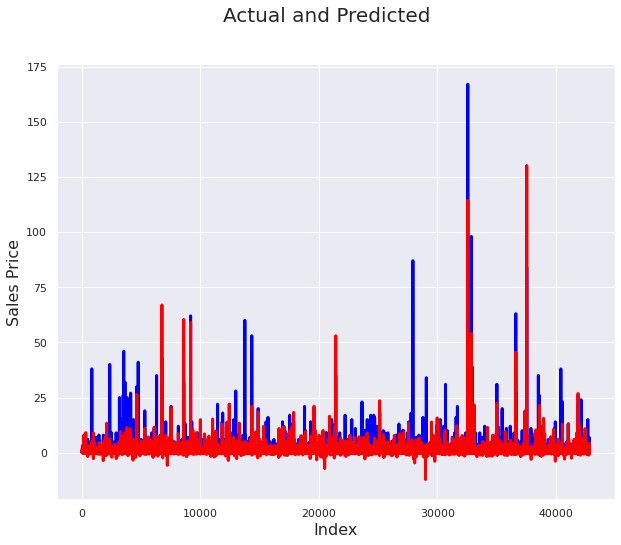

In [119]:
#Lasso visualization for train and test

colz = [i for i in range(0,y_test.shape[0],1)]

fig = plt.figure(figsize=(10,8))

plt.plot(colz,y_test,color='blue',linewidth=3.0,linestyle='-')

plt.plot(colz,y_pred_test,color='red',linewidth=3.0,linestyle='-')

fig.suptitle('Actual and Predicted', fontsize=20)

plt.xlabel('Index', fontsize=16)
plt.ylabel('Sales Price', fontsize=16) 

In [120]:
# Comparing the R2,RSS,MSE of Linear,Ridge and Lasso Regression

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                      'MSE (Train)','MSE (Test)'], 
            'Linear Regression' : sales_data_lr_metric
        }

      
lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(sales_data_ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(sales_data_lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric,rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.732878,0.732877,0.732878
1,R2 Score (Test),0.457699,0.457870,0.457726
2,RSS (Train),373065.848907,373066.605816,373065.891469
3,RSS (Test),73947.798718,73924.422932,73944.141005
4,MSE (Train),1.475496,2.177093,2.177089
5,MSE (Test),1.313826,1.725593,1.726054


In [121]:
model_lgb = LGBMRegressor( n_estimators=200,
                           learning_rate=0.03,
                           num_leaves=32,
                           colsample_bytree=0.9497036,
                           subsample=0.8715623,
                           max_depth=8,
                           reg_alpha=0.04,
                           reg_lambda=0.073,
                           min_split_gain=0.0222415,
                           min_child_weight=40)

In [122]:
model_lgb.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9497036, learning_rate=0.03, max_depth=8,
              min_child_weight=40, min_split_gain=0.0222415, n_estimators=200,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.8715623)

In [123]:
ridge.predict(X_test).clip(0,20)

array([0.07799502, 0.15813966, 0.37984013, ..., 0.01651547, 0.64327553,
       0.88422528])

In [124]:
lasso.predict(X_test).clip(0,20)

array([0.0779667 , 0.15867955, 0.38037626, ..., 0.01644769, 0.64402321,
       0.88495046])

In [125]:
model_lgb.predict(X_test).clip(0,20)

array([0.12502937, 0.36546161, 0.27303287, ..., 0.10716705, 0.6432327 ,
       0.39984063])

In [126]:
submission = pd.DataFrame({'ID':X_test.index,'item_cnt_month':model_lgb.predict(X_test).clip(0,20)})

In [127]:
submission.head()

,ID,item_cnt_month
0,100999,0.125029
1,41385,0.365462
2,129419,0.273033
3,129838,0.273033
4,10995,0.144929


In [128]:
submission.to_csv('submission.csv', index= False)